In [13]:
from typing import List, NoReturn, Union, Tuple, Optional, Text, Generic, Callable, Dict

import numpy as np 
import pandas as pd
from sklearn import *
import lightgbm as lgb
from catboost import Pool,CatBoostRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

import plotly.graph_objects as go
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

pd.set_option("display.precision", 8)

from functools import partial
import scipy as sp

import os
from sklearn.metrics import f1_score

import pywt 
from statsmodels.robust import mad

import scipy
from scipy import signal
from scipy.signal import butter, deconvolve, find_peaks, peak_widths, peak_prominences

from numpy.fft import *

import time
import math
from numba import jit
from math import log, floor
from sklearn.neighbors import KDTree

import itertools
import warnings
import time
import pywt
import os
import gc

train = pd.read_csv('/Users/siero5335/channel/train.csv')
test = pd.read_csv('/Users/siero5335/channel/test.csv')
train2 = pd.read_csv('/Users/siero5335/channel/train2.csv')
test2 = pd.read_csv('/Users/siero5335/channel/test2.csv')


sample_submission = pd.read_csv('/Users/siero5335/channel/sample_submission.csv')

train2 = train2.iloc[:,1]
test2 = test2.iloc[:,1]

train = pd.concat([train, train2], axis=1)
test = pd.concat([test, test2], axis=1)

In [15]:
train = train.drop('signal', axis = 1)
test = test.drop('signal', axis = 1)

train = train.rename(columns={'signal_chris': 'signal'})
test = test.rename(columns={'signal_chris': 'signal'})

train3 = pd.read_csv('/Users/siero5335/channel/train.csv')
train3['signal'] = train3['signal'].ewm(span=3).mean()
train3['time'] = train3['time'] + 500

train = pd.concat([train, train3])

del train2, test2, train3
gc.collect()

/Users/siero5335/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




52

In [16]:
train

,open_channels,signal,time
0,0,-2.76000000,0.0001
1,0,-2.85570000,0.0002
2,0,-2.40740000,0.0003
3,0,-3.14040000,0.0004
4,0,-3.15250000,0.0005
...,...,...,...
4999995,7,3.46115920,999.9996
4999996,7,3.07957960,999.9997
4999997,8,3.79798980,999.9998
4999998,9,4.71884490,999.9999


In [19]:
def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def high_pass_filter(x, low_cutoff=1000, sample_rate=10000):

    nyquist = 0.5 * sample_rate
    norm_low_cutoff = low_cutoff / nyquist
    print(norm_low_cutoff)
    sos = butter(10, Wn=[norm_low_cutoff], btype='highpass', output='sos')
    filtered_sig = signal.sosfilt(sos, x)

    return filtered_sig

def denoise_signal( x, wavelet='db4', level=1):
    
    coeff = pywt.wavedec( x, wavelet, mode="per" )
    sigma = (1/0.6745) * maddest( coeff[-level] )
    uthresh = sigma * np.sqrt( 2*np.log( len( x ) ) )
    coeff[1:] = ( pywt.threshold( i, value=uthresh, mode='hard' ) for i in coeff[1:] )
    return pywt.waverec( coeff, wavelet, mode='per' )

train['signal_wave'] = denoise_signal(train['signal'])
test['signal_wave'] = denoise_signal(test['signal'])

In [20]:
def filter_signal(signal, threshold=1e8):
    fourier = rfft(signal)
    frequencies = rfftfreq(signal.size, d=20e-3/signal.size)
    fourier[frequencies > threshold] = 0
    return irfft(fourier)

train['signal_FFT_1e5'] = filter_signal(train['signal'], threshold=5e3)
test['signal_FFT_1e5'] = filter_signal(test['signal'], threshold=5e3)

In [21]:
def _embed(x, order=3, delay=1):
    N = len(x)
    if order * delay > N:
        raise ValueError("Error: order * delay should be lower than x.size")
    if delay < 1:
        raise ValueError("Delay has to be at least 1.")
    if order < 2:
        raise ValueError("Order has to be at least 2.")
    Y = np.zeros((order, N - (order - 1) * delay))
    for i in range(order):
        Y[i] = x[i * delay:i * delay + Y.shape[1]]
    return Y.T

all = ['perm_entropy', 'spectral_entropy', 'svd_entropy', 'app_entropy',
       'sample_entropy']


def perm_entropy(x, order=3, delay=1, normalize=False):
    x = np.array(x)
    ran_order = range(order)
    hashmult = np.power(order, ran_order)
    # Embed x and sort the order of permutations
    sorted_idx = _embed(x, order=order, delay=delay).argsort(kind='quicksort')
    # Associate unique integer to each permutations
    hashval = (np.multiply(sorted_idx, hashmult)).sum(1)
    # Return the counts
    _, c = np.unique(hashval, return_counts=True)
    # Use np.true_divide for Python 2 compatibility
    p = np.true_divide(c, c.sum())
    pe = -np.multiply(p, np.log2(p)).sum()
    if normalize:
        pe /= np.log2(factorial(order))
    return pe

In [22]:
def _log_n(min_n, max_n, factor):
    max_i = int(floor(log(1.0 * max_n / min_n) / log(factor)))
    ns = [min_n]
    for i in range(max_i + 1):
        n = int(floor(min_n * (factor ** i)))
        if n > ns[-1]:
            ns.append(n)
    return np.array(ns, dtype=np.int64)

def _higuchi_fd(x, kmax):
    n_times = x.size
    lk = np.empty(kmax)
    x_reg = np.empty(kmax)
    y_reg = np.empty(kmax)
    for k in range(1, kmax + 1):
        lm = np.empty((k,))
        for m in range(k):
            ll = 0
            n_max = floor((n_times - m - 1) / k)
            n_max = int(n_max)
            for j in range(1, n_max):
                ll += abs(x[m + j * k] - x[m + (j - 1) * k])
            ll /= k
            ll *= (n_times - 1) / (k * n_max)
            lm[m] = ll
        # Mean of lm
        m_lm = 0
        for m in range(k):
            m_lm += lm[m]
        m_lm /= k
        lk[k - 1] = m_lm
        x_reg[k - 1] = log(1. / k)
        y_reg[k - 1] = log(m_lm)
    higuchi, _ = _linear_regression(x_reg, y_reg)
    return higuchi


def higuchi_fd(x, kmax=10):
    x = np.asarray(x, dtype=np.float64)
    kmax = int(kmax)
    return _higuchi_fd(x, kmax)

def _linear_regression(x, y):
    n_times = x.size
    sx2 = 0
    sx = 0
    sy = 0
    sxy = 0
    for j in range(n_times):
        sx2 += x[j] ** 2
        sx += x[j]
        sxy += x[j] * y[j]
        sy += y[j]
    den = n_times * sx2 - (sx ** 2)
    num = n_times * sxy - sx * sy
    slope = num / den
    intercept = np.mean(y) - slope * np.mean(x)
    return slope, intercept

In [23]:
def katz_fd(x):
    x = np.array(x)
    dists = np.abs(np.ediff1d(x))
    ll = dists.sum()
    ln = np.log10(np.divide(ll, dists.mean()))
    aux_d = x - x[0]
    d = np.max(np.abs(aux_d[1:]))
    return np.divide(ln, np.add(ln, np.log10(np.divide(d, ll))))

In [24]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        if col!='open_channels':
            col_type = df[col].dtypes
            if col_type in numerics:
                c_min = df[col].min()
                c_max = df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)  
                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [25]:
def p1( x : pd.Series) -> pd.Series : return x.quantile(0.01)
def p5(x : pd.Series) -> pd.Series : return x.quantile(0.05)
def p95( x : pd.Series) -> pd.Series : return x.quantile(0.95)
def p99(x : pd.Series) -> pd.Series : return x.quantile(0.99)

In [26]:
zscore = lambda x: (x - x.mean()) / x.std()

window_sizes = [5, 10, 25, 50, 100, 500, 1000, 5000]

for window in window_sizes:
    train["rolling_mean_" + str(window)] = train['signal'].rolling(window=window).mean()
    train["rolling_std_" + str(window)] = train['signal'].rolling(window=window).std()
    train["rolling_min_" + str(window)] = train['signal'].rolling(window=window).min()
    train["rolling_max_" + str(window)] = train['signal'].rolling(window=window).max()
    
for window in window_sizes:
    test["rolling_mean_" + str(window)] = test['signal'].rolling(window=window).mean()
    test["rolling_std_" + str(window)] = test['signal'].rolling(window=window).std()
    test["rolling_min_" + str(window)] = test['signal'].rolling(window=window).min()
    test["rolling_max_" + str(window)] = test['signal'].rolling(window=window).max()
    
def features(df):
    df = df.sort_values(by=['time']).reset_index(drop=True)
    df.index = ((df.time * 10_000) - 1).values
    df['batch'] = df.index // 50_000
    df['batch_index'] = df.index  - (df.batch * 50_000)
    df['batch_slices'] = df['batch_index']  // 5_000
    df['batch_slices2'] = df.apply(lambda r: '_'.join([str(r['batch']).zfill(3), str(r['batch_slices']).zfill(3)]), axis=1)
    
    for c in ['batch','batch_slices2']:
        d = {}
                                            
        d['mean'+c] = df.groupby([c])['signal'].mean()
        d['median'+c] = df.groupby([c])['signal'].median()
        d['max'+c] = df.groupby([c])['signal'].max()
        d['min'+c] = df.groupby([c])['signal'].min()
        d['std'+c] = df.groupby([c])['signal'].std()
        d['skew'+c] = df.groupby([c])['signal'].skew()
        
        d['q1'+c] = df.groupby([c])['signal'].apply(lambda x:p1(x))
        d['q5'+c] = df.groupby([c])['signal'].apply(lambda x:p5(x))
        d['q95'+c] = df.groupby([c])['signal'].apply(lambda x:p95(x))       
        d['q99'+c] = df.groupby([c])['signal'].apply(lambda x:p99(x))                   
        
        d['signal_batch'+c] = df.groupby([c])['signal'].transform(zscore)
        d['perm'+c] = df.groupby([c])['signal'].apply(lambda x:perm_entropy(x))
        d['higuchi'+c] = df.groupby([c])['signal'].apply(lambda x:higuchi_fd(x))
        d['katz'+c] = df.groupby([c])['signal'].apply(lambda x:katz_fd(x))
                
        d['mean_abs_chg'+c] = df.groupby([c])['signal'].apply(lambda x: np.mean(np.abs(np.diff(x))))
        d['abs_max'+c] = df.groupby([c])['signal'].apply(lambda x: np.max(np.abs(x)))
        d['abs_min'+c] = df.groupby([c])['signal'].apply(lambda x: np.min(np.abs(x)))
        for v in d:
            df[v] = df[c].map(d[v].to_dict())
        df['range'+c] = df['max'+c] - df['min'+c]
        df['maxtomin'+c] = df['max'+c] / df['min'+c]
        df['abs_avg'+c] = (df['abs_min'+c] + df['abs_max'+c]) / 2
    
 
    for c in [c1 for c1 in df.columns if c1 not in ['time', 'signal', 'open_channels', 'batch', 'batch_index', 'batch_slices', 'batch_slices2']]:
        df[c+'_msignal'] = df[c] - df['signal']
        
    return df

train = features(train)
test = features(test)

train['signal_shift+1'] = train.groupby(['batch']).shift(1)['signal']
test['signal_shift+1'] = test.groupby(['batch']).shift(1)['signal']
train['signal_shift-1'] = train.groupby(['batch']).shift(-1)['signal']
test['signal_shift-1'] = test.groupby(['batch']).shift(-1)['signal']


train['signal_shift+1_msignal'] = train['signal_shift+1'] - train['signal']
test['signal_shift+1_msignal'] = test['signal_shift+1'] - test['signal']
train['signal_shift-1_msignal'] = train['signal_shift-1'] - train['signal']
test['signal_shift-1_msignal'] = test['signal_shift-1'] - test['signal']


train['signal_shift+2'] = train.groupby(['batch']).shift(2)['signal']
test['signal_shift+2'] = test.groupby(['batch']).shift(2)['signal']
train['signal_shift-2'] = train.groupby(['batch']).shift(-2)['signal']
test['signal_shift-2'] = test.groupby(['batch']).shift(-2)['signal']


train['signal_shift+2_msignal'] = train['signal_shift+2'] - train['signal']
test['signal_shift+2_msignal'] = test['signal_shift+2'] - test['signal']
train['signal_shift-2_msignal'] = train['signal_shift-2']  - train['signal']
test['signal_shift-2_msignal'] = test['signal_shift-2'] - test['signal']



train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

train_y = train['open_channels']

In [27]:
train.head()

,open_channels,signal,time,signal_wave,signal_FFT_1e5,rolling_mean_5,rolling_std_5,rolling_min_5,rolling_max_5,rolling_mean_10,...,maxtominbatch_slices2_msignal,abs_avgbatch_slices2_msignal,signal_shift+1,signal_shift-1,signal_shift+1_msignal,signal_shift-1_msignal,signal_shift+2,signal_shift-2,signal_shift+2_msignal,signal_shift-2_msignal
0.0,0,-2.7600,0.0001,-1.89005403,0.52695232,0.0000,0.00000000,0.0000,0.0000,0.0,...,3.2788879,5.4861,0.0000,-2.8557,0.0000,-0.0957,0.0000,-2.4074,0.0000,0.3526
1.0,0,-2.8557,0.0002,-2.89182770,0.52681580,0.0000,0.00000000,0.0000,0.0000,0.0,...,3.3745879,5.5818,-2.7600,-2.4074,0.0957,0.4483,0.0000,-3.1404,0.0000,-0.2847
2.0,0,-2.4074,0.0003,-0.66360106,0.52667928,0.0000,0.00000000,0.0000,0.0000,0.0,...,2.9262879,5.1335,-2.8557,-3.1404,-0.4483,-0.7330,-2.7600,-3.1525,-0.3526,-0.7451
3.0,0,-3.1404,0.0004,-1.05819268,0.52654275,0.0000,0.00000000,0.0000,0.0000,0.0,...,3.6592879,5.8665,-2.4074,-3.1525,0.7330,-0.0121,-2.8557,-2.6418,0.2847,0.4986
4.0,0,-3.1525,0.0005,-3.12687394,0.52640623,-2.8632,0.30781263,-3.1525,-2.4074,0.0,...,3.6713879,5.8786,-3.1404,-2.6418,0.0121,0.5107,-2.4074,-2.6993,0.7451,0.4532


In [28]:
test.head()

,time,signal,signal_wave,signal_FFT_1e5,rolling_mean_5,rolling_std_5,rolling_min_5,rolling_max_5,rolling_mean_10,rolling_std_10,...,maxtominbatch_slices2_msignal,abs_avgbatch_slices2_msignal,signal_shift+1,signal_shift-1,signal_shift+1_msignal,signal_shift-1_msignal,signal_shift+2,signal_shift-2,signal_shift+2_msignal,signal_shift-2_msignal
5000000.0,500.0001,-2.64983,-2.70763568,-2.68908707,0.00000,0.00000000,0.00000,0.00000,0.0,0.0,...,3.17009639,5.33440,0.00000,-2.84946,0.00000,-0.19963,0.00000,-2.86009,0.00000,-0.21026
5000001.0,500.0002,-2.84946,-2.70762149,-2.68908862,0.00000,0.00000000,0.00000,0.00000,0.0,0.0,...,3.36972639,5.53403,-2.64983,-2.86009,0.19963,-0.01063,0.00000,-2.43512,0.00000,0.41434
5000002.0,500.0003,-2.86009,-2.70760720,-2.68909018,0.00000,0.00000000,0.00000,0.00000,0.0,0.0,...,3.38035639,5.54466,-2.84946,-2.43512,0.01063,0.42497,-2.64983,-2.61565,0.21026,0.24444
5000003.0,500.0004,-2.43512,-2.70759352,-2.68909172,0.00000,0.00000000,0.00000,0.00000,0.0,0.0,...,2.95538639,5.11969,-2.86009,-2.61565,-0.42497,-0.18053,-2.84946,-2.56608,-0.41434,-0.13096
5000004.0,500.0005,-2.61565,-2.70758051,-2.68909327,-2.68203,0.17758509,-2.86009,-2.43512,0.0,0.0,...,3.13591639,5.30022,-2.43512,-2.56608,0.18053,0.04957,-2.86009,-2.73801,-0.24444,-0.12236


In [29]:
#train.to_csv('/Users/siero5335/channel/train_mod.csv')
#test.to_csv('/Users/siero5335/channel/test_mod.csv')

In [30]:
col = [c for c in train.columns if c not in ['time', 'open_channels', 'batch', 'batch_index', 'batch_slices', 'batch_slices2']]

train = train[col]
test = test[col]

n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)

In [39]:
oof = np.zeros(len(train))
prediction = np.zeros(len(test))
scores = []

params = {'learning_rate': 0.05, 'max_depth': -1, 'num_leaves':2**7+1, 'metric': 'mae', 'random_state': 7, 'n_jobs':-1} 

for fold_n, (train_index, valid_index) in enumerate(folds.split(train, train_y)):
    print('Fold', fold_n, 'started at', time.ctime())
    X_train, X_valid = train.iloc[train_index], train.iloc[valid_index]
    y_train, y_valid = train_y.iloc[train_index], train_y.iloc[valid_index]
    
    model = lgb.LGBMRegressor(**params, n_estimators = 15000)
    model.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='mae',
            verbose=100, early_stopping_rounds=50)

    y_pred_valid = model.predict(X_valid)
    y_pred = model.predict(test, num_iteration=model.best_iteration_)

    oof[valid_index] = y_pred_valid.reshape(-1,)
    scores.append(mean_absolute_error(y_valid, y_pred_valid))

    prediction += y_pred

prediction /= n_fold

Fold 0 started at Thu Mar 12 15:00:06 2020
Training until validation scores don't improve for 50 rounds
[100]	training's l1: 0.0767494	valid_1's l1: 0.0770502
[200]	training's l1: 0.0679844	valid_1's l1: 0.0684086
[300]	training's l1: 0.0667886	valid_1's l1: 0.067392
[400]	training's l1: 0.0658881	valid_1's l1: 0.0666758
[500]	training's l1: 0.0650703	valid_1's l1: 0.0660455
[600]	training's l1: 0.0642095	valid_1's l1: 0.0653591
[700]	training's l1: 0.0634523	valid_1's l1: 0.064782
[800]	training's l1: 0.0629271	valid_1's l1: 0.0644459
[900]	training's l1: 0.0624282	valid_1's l1: 0.0641329
[1000]	training's l1: 0.0620012	valid_1's l1: 0.0638928
[1100]	training's l1: 0.0616006	valid_1's l1: 0.0636692
[1200]	training's l1: 0.0611703	valid_1's l1: 0.0634232
[1300]	training's l1: 0.0607244	valid_1's l1: 0.0631543
[1400]	training's l1: 0.060367	valid_1's l1: 0.062973
[1500]	training's l1: 0.0600284	valid_1's l1: 0.0628009
[1600]	training's l1: 0.0597078	valid_1's l1: 0.0626503
[1700]	traini

In [40]:
class OptimizedRounder(object):
    """
    An optimizer for rounding thresholds
    to maximize F1 (Macro) score
    # https://www.kaggle.com/naveenasaithambi/optimizedrounder-improved
    """
    def __init__(self):
        self.coef_ = 0

    def _f1_loss(self, coef, X, y):
        """
        Get loss according to
        using current coefficients
        
        :param coef: A list of coefficients that will be used for rounding
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        X_p = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

        return -f1_score(y, X_p, average = 'macro')

    def fit(self, X, y):
        """
        Optimize rounding thresholds
        
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        loss_partial = partial(self._f1_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        """
        Make predictions with specified thresholds
        
        :param X: The raw predictions
        :param coef: A list of coefficients that will be used for rounding
        """
        return pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])


    def coefficients(self):
        """
        Return the optimized coefficients
        """
        return self.coef_['x']

In [41]:
optR = OptimizedRounder()
optR.fit(oof.reshape(-1,), train_y)
coefficients = optR.coefficients()
print(coefficients)

[0.50952056 1.52387822 2.51116428 3.49312572 4.49837454 5.48658914
 6.49729232 7.50291307 8.48359763 9.4769312 ]


In [42]:
opt_preds = optR.predict(oof.reshape(-1,), coefficients)
f1_score(train_y, opt_preds, average = 'macro')

0.9373392551673995

In [43]:
prediction[prediction <= coefficients[0]] = 0
prediction[np.where(np.logical_and(prediction > coefficients[0], prediction <= coefficients[1]))] = 1
prediction[np.where(np.logical_and(prediction > coefficients[1], prediction <= coefficients[2]))] = 2
prediction[np.where(np.logical_and(prediction > coefficients[2], prediction <= coefficients[3]))] = 3
prediction[np.where(np.logical_and(prediction > coefficients[3], prediction <= coefficients[4]))] = 4
prediction[np.where(np.logical_and(prediction > coefficients[4], prediction <= coefficients[5]))] = 5
prediction[np.where(np.logical_and(prediction > coefficients[5], prediction <= coefficients[6]))] = 6
prediction[np.where(np.logical_and(prediction > coefficients[6], prediction <= coefficients[7]))] = 7
prediction[np.where(np.logical_and(prediction > coefficients[7], prediction <= coefficients[8]))] = 8
prediction[np.where(np.logical_and(prediction > coefficients[8], prediction <= coefficients[9]))] = 9
prediction[prediction > coefficients[9]] = 10

In [44]:
sample_submission['open_channels'] = prediction.astype(np.int)
sample_submission.to_csv('submission_reg20200311_mae_5cv_emaplus.csv', index=False, float_format='%.4f')

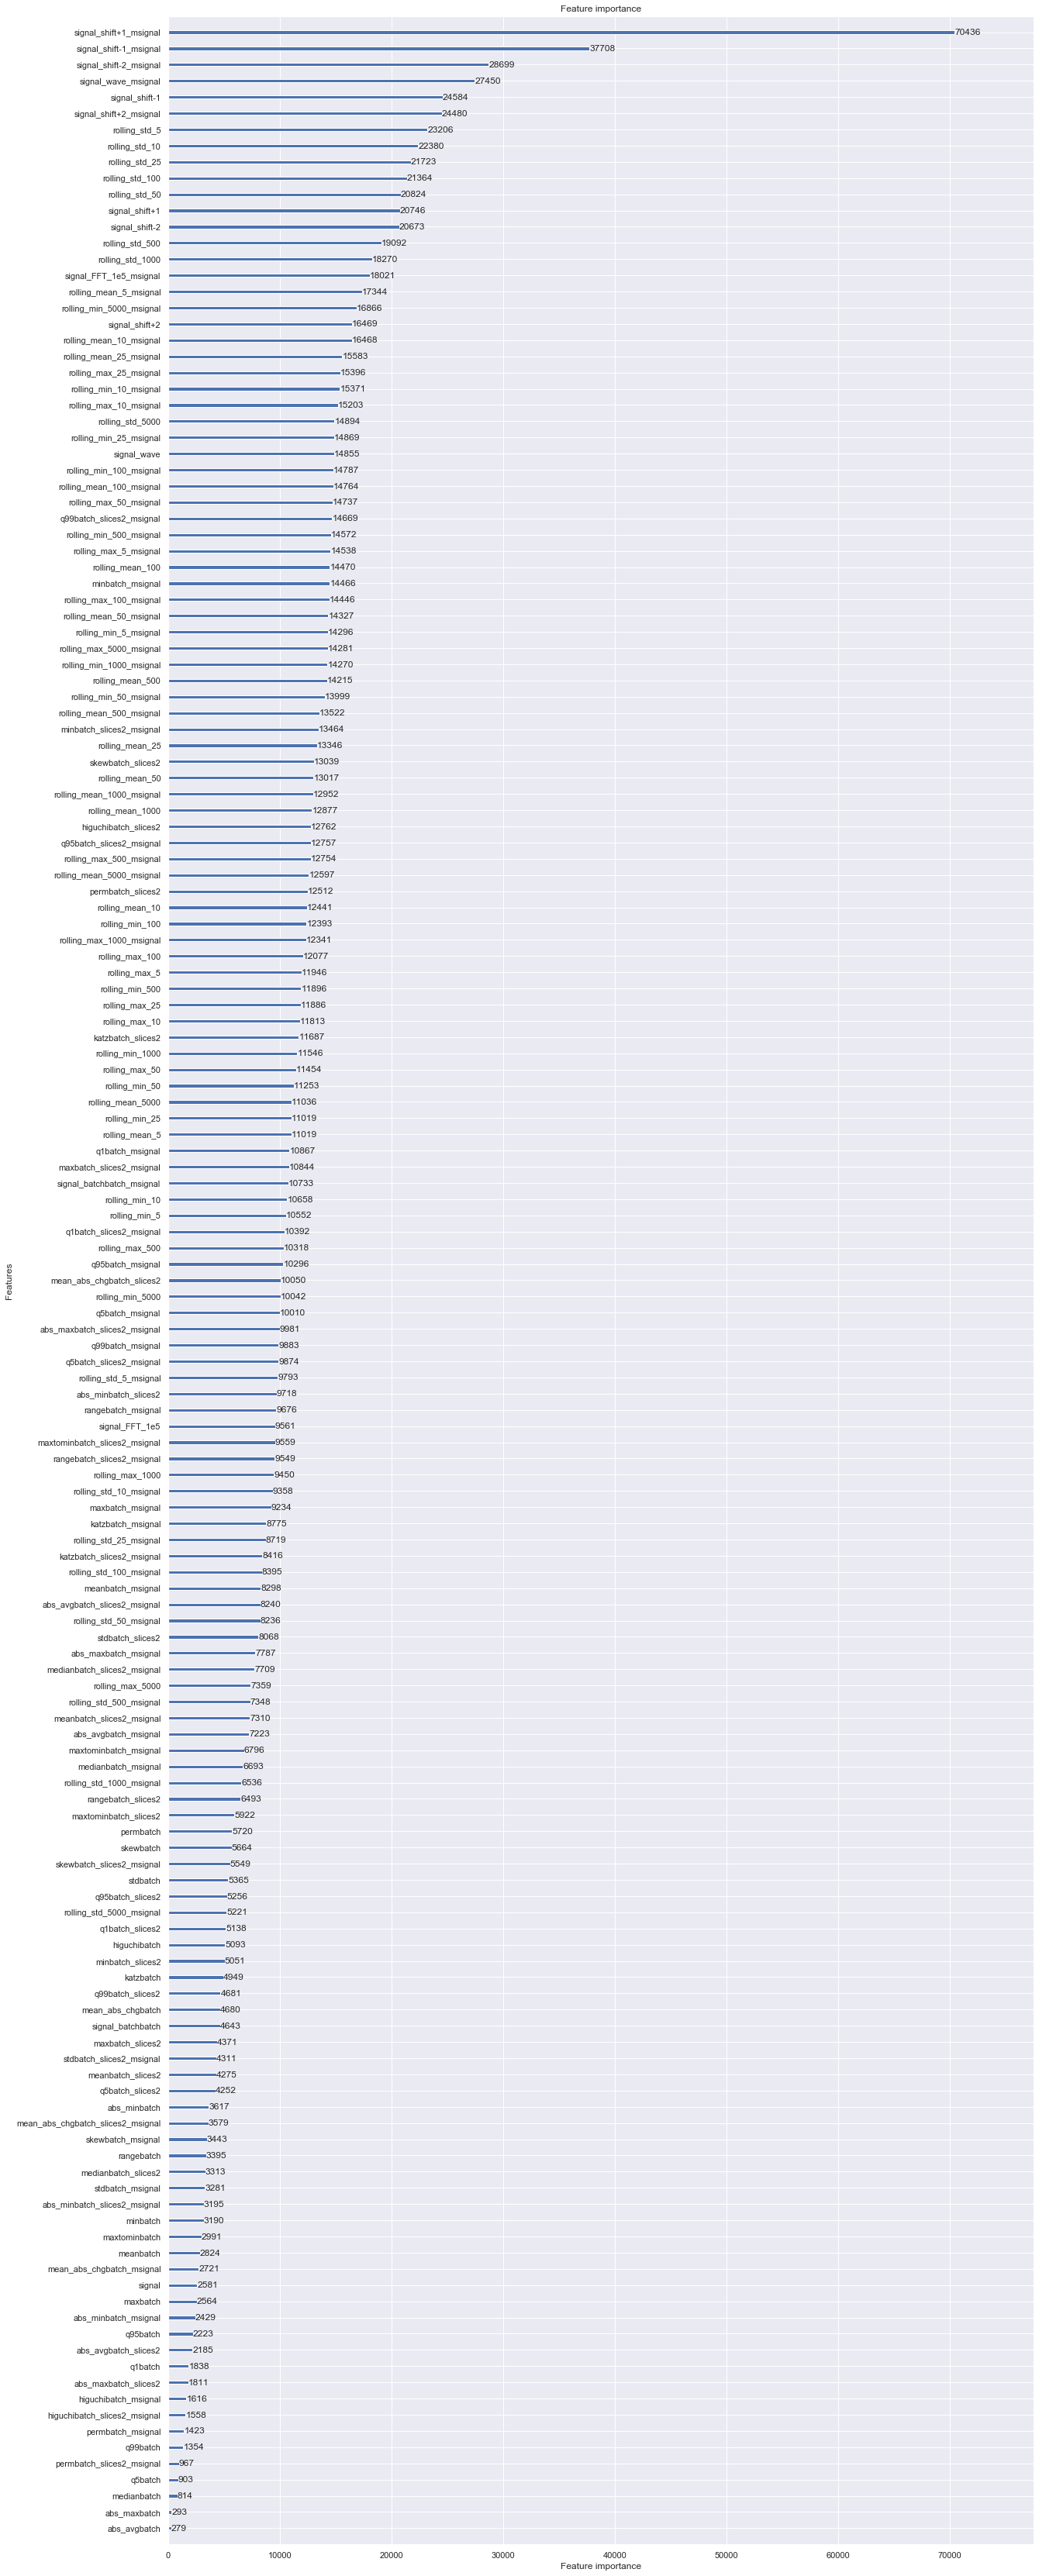

In [45]:
lgb.plot_importance(model,importance_type='split', max_num_features=230, figsize=(20, 60))